# import

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import Normalizer

norm_l2 = Normalizer(norm='l2')

# tools

In [48]:
def gram_schmidt(A):
    """Gram-schmidt正交化"""
    Q=np.zeros_like(A)
    cnt = 0
    for a in A.T:
        u = np.copy(a)
        for i in range(0, cnt):
            u -= np.dot(np.dot(Q[:, i].T, a), Q[:, i]) # 减去待求向量在以求向量上的投影
        e = u / np.linalg.norm(u)  # 归一化
        Q[:, cnt] = e
        cnt += 1
    R = np.dot(Q.T, A)
    return Q

# 问题

- 从求解问题上：
    - 近似最近邻
    - k-近似近邻
    - （估计近似对大小）
- 从数据对象上：
    - 度量空间（Hamming, Euclidean, ...）
    - 数据类型

**确定要解决的问题后**

# 方法

- 脑洞大开
- 最近看的有思路的论文作为基础方法，并在其上进行扩展，提升性能
- 实现论文后发现与结果有出入，可适当深入研究一下，或许能找到该论文的漏洞，并对其进行补充

**例: OPRCP**

## For Hamming: OPR

- **min-hash**
    - 简介
        > 打乱数据 $k$ 次，取每一次首位非零索引
    - 缺点
        > 需打乱 $k$ 次
- **CRS (Conditinal Random Sampling)**
    - 简介
        > 打乱 **1** 次，取最小的 $k$ 个非零索引
    - 缺点
        > 取样不对称
- **OP (One Permutation Hashing)**
    - 简介
        > 打乱 **1** 次，将数据分为 $k$ 段（每段长 $\frac{d}{k}$）
        >
        > 取每一段首位 **非空** 索引
    - 缺点
        > 对于全零的处理策略问题
        > 1. 设为固定值，文本数据极其稀疏，将全0设为固定值，会提高数据间的相似性
        > 2. 设为随机值，降低相似性
- **OPR (One Permutation with Rotation Hashing)**
    - 简介
        > 打乱 **1** 次，将数据分为 $k$ 段（每段长 $\frac{d}{k}$）
        >
        > 取每一段首位 **非空** 索引
        >
        > 对于 **全0** 索引，取右侧首个 **非空段的hash值**

$$
\text{OPR($\pi(S_1)$)} = [E, 1, E, 2, 0, 1] \rightarrow H(\pi(S_1))=[1+C, 1, 2+C, 2, 0, 1] \\
\text{OPR($\pi(S_2)$)} = [E, 1, E, 0, 0, E] \rightarrow H(\pi(S_2))=[1+C, 1, C, 0, 0, 1+2C] 
$$

## For Euclidean CP (Cross-polytope Hashing)

In [2]:
P = datasets.make_blobs(centers=10, n_samples=100, n_features=2, random_state=1, cluster_std=10)[0]
P = P - P.mean(axis=0)
S = norm_l2.fit_transform(P)

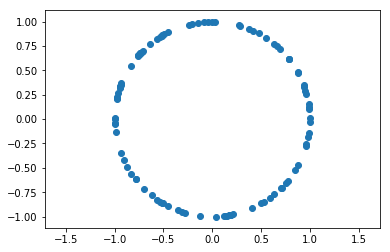

In [4]:
plt.scatter(S[:, 0], S[:, 1])
plt.axis('equal')
plt.show()

**hyperplane hashing**

In [17]:
def generate_hyperplane(d, random_state=None):
    if random_state is not None:
        rand = np.random.RandomState(random_state)
    else:
        rand = np.random.RandomState()

    v = norm_l2.fit_transform(rand.normal(0, 1, (1, d)))[0]
    return v

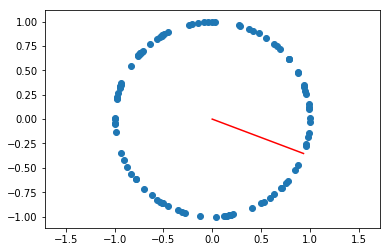

In [27]:
v = generate_hyperplane(2, random_state=1)
plt.scatter(S[:, 0], S[:, 1])
plt.plot([0, v[0]], [0, v[1]], c='r')
plt.axis('equal')
plt.show()

In [23]:
H = (S.dot(v) >= 0).astype(np.int)

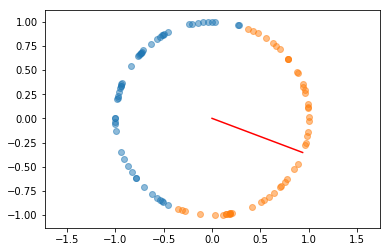

In [28]:
plt.scatter(S[H==0, 0], S[H==0, 1], alpha=0.5)
plt.scatter(S[H==1, 0], S[H==1, 1], alpha=0.5)
plt.plot([0, v[0]], [0, v[1]], c='r')
plt.axis('equal')
plt.show()

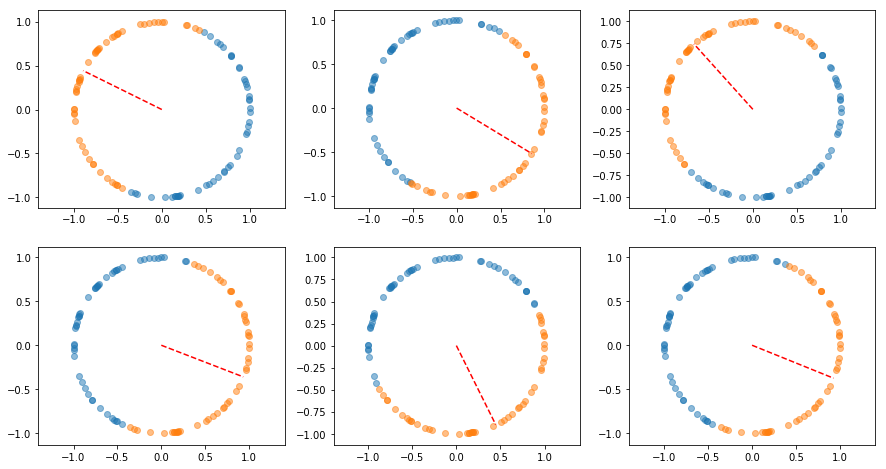

In [41]:
V = [generate_hyperplane(2) for i in range(6)]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, v in enumerate(V):
    H = (S.dot(v) >= 0).astype(np.int)
    axes[i // 3][i % 3].scatter(S[H==0, 0], S[H==0, 1], alpha=0.5)
    axes[i // 3][i % 3].scatter(S[H==1, 0], S[H==1, 1], alpha=0.5)
    axes[i // 3][i % 3].plot([0, v[0]], [0, v[1]], 'r--', )
    axes[i // 3][i % 3].axis('equal')

假设两个点 $p, q$ 的角度为 $\alpha$, 
则 
$$
Pr[h(a) = h(b)] = 1 - \frac{\alpha}{\pi}
$$

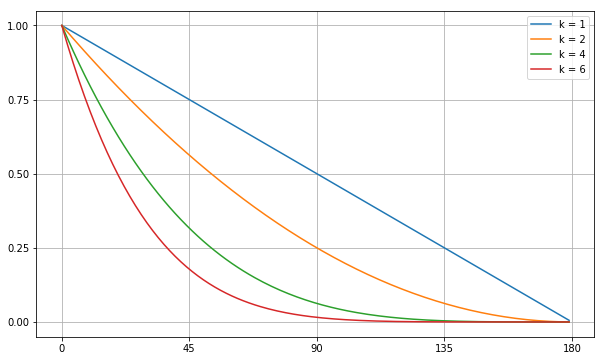

In [47]:
plt.figure(figsize=(10, 6))
Alpha = np.arange(0, 180, 1)
focus_alpha = np.array([0, 45, 90, 135, 180])
Pr = 1 - Alpha / 180
plt.plot(Alpha, Pr, label='k = 1')
K = np.arange(2, 8, 2)
for k in K:
    plt.plot(Alpha, Pr ** k, label='k = {}'.format(k))
plt.xticks(focus_alpha)
plt.yticks(1 - focus_alpha / 180)
plt.grid()
plt.legend()
plt.show()

In [94]:
def generate_voronoi_guassian(T, d, random_state=None):
    if random_state is not None:
        rand = np.random.RandomState(random_state)
    else:
        rand = np.random.RandomState()
    return norm_l2.fit_transform(rand.normal(0, 1, (T, d)))

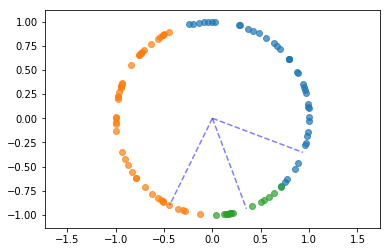

In [106]:
G = generate_voronoi_guassian(T=3, d=2, random_state=1)
h = np.array([S.dot(g) for g in G])
H = h.T.argmax(axis=1)
for i in range(G.shape[0]):
    plt.scatter(S[H==i, 0], S[H==i, 1], alpha=0.7)
for g in G:
    plt.plot([0, g[0]], [0, g[1]], 'b--', alpha=0.5)
plt.axis('equal')
plt.show()

$$
T=2^k
$$

![1](./img/1.png)

### cross-polytope hashing

![1](./img/cross-polytope-d=2.png)

![2](./img/cross-polytope-d=3.png)

In [67]:
def generate_e(d, rand):
    A = np.random.normal(0, 1, (d, d))
    A = norm_l2.fit_transform(gram_schmidt(A))
    A = np.append(A, -A).reshape(-1, d)
    return A

def cross_polytope(P, random_state=None):
    if random_state is not None:
        rand = np.random.RandomState(random_state)
    else:
        rand = np.random.RandomState()
    d = P.shape[1]
    
    # generate e
    e = rand.normal(0, 1, (d, d))
    e = norm_l2.fit_transform(gram_schmidt(e))
    e = np.append(e, -e).reshape(-1, d)

    A = norm_l2.fit_transform(rand.normal(0, 1, (d, d)))

    rotate = np.array([A.dot(p) / np.sqrt(np.sum(A.dot(p) ** 2)) for p in P])

    H = rotate.dot(e.T).argmax(axis=1)
    parts = []
    
    for i in range(e.shape[0]):
        parts.append(P[H==i])
        
    return e, A, H, np.array(parts)

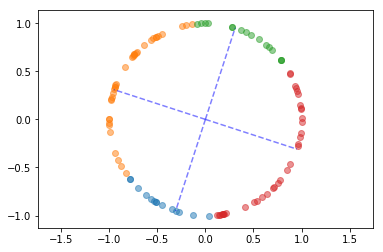

In [68]:
e, A, H, parts = cross_polytope(S, 1)
for i in range(e.shape[0]):
    plt.scatter(parts[i][:, 0], parts[i][:, 1], alpha=0.5)
for _e in e:
    plt.plot([0, _e[0]], [0, _e[1]], 'b--', alpha=0.5)
plt.axis('equal')
plt.show()

**数据集满足的条件**
- 最近邻与查询点的距离在 $0 \rightarrow \sqrt 2$
- 且主要集中在$\frac{\sqrt 2}{2}$左右

## 连接hash值

$$
H=(H_1, H_2)
$$

# 关于论文实验部分的一点小心得

## 实验部分做到什么程度是比较完善的？

- 数据集
- 评测指标
- 对比方法

## 如何开始一个实验？

### 常用的实验结构

- package
    - numpy, matplotlib, sklearn, scipy, ...
- tools
    - md5, ...
- datasets
- metrics
- test
- main
- plot

### datasets

- 数据集的获取
    - 真实数据集
    > 算法对比实验
    
        - UCI Machine Learning Repository
        - Euclidean:
            - SIFT
            - MNIST
            - ...
        - Hamming:
            - MNIST
            - NYTimes
            - ...
    - 生成数据集
    > 评估算法参数
    
        - sklearn.datasets
        - n, d 两个方面进行控制变量生成
        
- TIPS
    - 单独的数据集代码文件

In [116]:
%store -r Datasets

In [117]:
Datasets.keys()

dict_keys(['SIFT-10K'])

In [119]:
Datasets['SIFT-10K'].keys()

dict_keys(['title', 'train', 'test', 'K', 'n_train', 'n_test', 'k_near_neighbors', 'nearest_neighbor'])

In [122]:
Datasets['SIFT-10K']

{'title': 'SIFT-10K', 'train': array([[ 0, 16, 35, ..., 25, 23,  1],
        [14, 35, 19, ..., 11, 21, 33],
        [ 0,  1,  5, ...,  4, 23, 10],
        ...,
        [48,  1,  0, ..., 22, 62, 18],
        [ 0,  0,  0, ...,  3,  3, 11],
        [14,  2,  0, ...,  0,  0,  7]]), 'test': array([[ 1,  3, 11, ..., 42, 48, 11],
        [40, 25, 11, ...,  3, 19, 13],
        [28,  4,  3, ...,  2, 54, 47],
        ...,
        [14,  8,  0, ..., 32, 14, 15],
        [11, 48, 10, ...,  0,  0,  0],
        [ 4, 10,  5, ..., 43,  0,  8]]), 'K': 50, 'n_train': 10000, 'n_test': 100, 'k_near_neighbors': [array([2176, 3752,  882, 4009, 2837,  190, 3615,  816, 1045, 1884,  224,
         3013,  292, 1272, 5307, 4938, 1295,  492, 9211, 3625, 1254, 1292,
         1625, 3553, 1156,  146,  107, 5231, 1995, 9541, 3543, 9758, 9806,
         1064, 9701, 4064, 2456, 2763, 3237, 1317, 3530,  641, 1710, 8887,
         4263, 1756,  598,  370, 2776,  121]),
  array([2781, 9574, 2492, 1322, 3136, 1038, 9564,  925, 

### metrics

- 充分且被广泛接受（7种）
- 凸显算法的优点

#### 常用
- 查询到最近邻的概率
- 错误率
- 精确率
- 召回率
- F1 值
- 选择率（候选集数量）
- 哈希时间
- 总查询时间

**统一的接口**

In [125]:
def metrics(P, query_func, args, test, 
            nearest_neighbor, k_near_neighbors, verbose=False):
    """
    Desc:
        评估
            1. 查询到最近邻的概率
            2. 准确率(现更改为错误率 error_ratio)
            3. 召回率
            4. 候选集数量(现改成 selectivity, 候选数量/数据集大小)
            5. 哈希时间
            6. 查询时间(最近邻)
            7. 空间消耗由于不同方法存储结构不同，放至函数体外
    Args:
        P: 数据集
        query_func: 查询函数
        args: 查询函数所需参数
        test: 测试集
        nearest_neighbor: 精确的最近邻
        k_near_neighbors: 精确的k-近邻
    """
    pass

In [127]:
print(metrics.__doc__)


    Desc:
        评估
            1. 查询到最近邻的概率
            2. 准确率(现更改为错误率 error_ratio)
            3. 召回率
            4. 候选集数量(现改成 selectivity, 候选数量/数据集大小)
            5. 哈希时间
            6. 查询时间(最近邻)
            7. 空间消耗由于不同方法存储结构不同，放至函数体外
    Args:
        P: 数据集
        query_func: 查询函数
        args: 查询函数所需参数
        test: 测试集
        nearest_neighbor: 精确的最近邻
        k_near_neighbors: 精确的k-近邻
    


### test

实验与阅读论文结合

### main

**对比实验**
- 充分
- 算法所基于的论文（递归）

**优化问题**

### plot

**需要有哪些图？**

- 参数变换比较图

![3](./img/pic-exp.png)

- 对比图

![4](./img/pic-img-2.png)

文字的分析部分？
- 是否需要详细的文字解读